In [1]:
# imports from hollance
import os, sys
import numpy as np
import pandas as pd

import joblib

%matplotlib inline
import matplotlib.pyplot as plt

from collections import OrderedDict

import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, roc_auc_score

Define reliability curve functions

In [2]:
## Functions for Reliability diagrams (checks calibration). Use this to check before and after logistic regression to see if it calibrates it well

# code taken from: https://github.com/hollance/reliability-diagrams/blob/master/reliability_diagrams.py

def compute_calibration(true_labels, pred_labels, confidences, num_bins=10):
    """Collects predictions into bins used to draw a reliability diagram.
    Arguments:
        true_labels: the true labels for the test examples
        pred_labels: the predicted labels for the test examples
        confidences: the predicted confidences for the test examples
        num_bins: number of bins
    The true_labels, pred_labels, confidences arguments must be NumPy arrays;
    pred_labels and true_labels may contain numeric or string labels.
    For a multi-class model, the predicted label and confidence should be those
    of the highest scoring class.
    Returns a dictionary containing the following NumPy arrays:
        accuracies: the average accuracy for each bin
        confidences: the average confidence for each bin
        counts: the number of examples in each bin
        bins: the confidence thresholds for each bin
        avg_accuracy: the accuracy over the entire test set
        avg_confidence: the average confidence over the entire test set
        expected_calibration_error: a weighted average of all calibration gaps
        max_calibration_error: the largest calibration gap across all bins
    """
    assert(len(confidences) == len(pred_labels))
    assert(len(confidences) == len(true_labels))
    assert(num_bins > 0)

    bin_size = 1.0 / num_bins
    bins = np.linspace(0.0, 1.0, num_bins + 1)
    indices = np.digitize(confidences, bins, right=True)

    bin_accuracies = np.zeros(num_bins, dtype=float)
    bin_confidences = np.zeros(num_bins, dtype=float)
    bin_counts = np.zeros(num_bins, dtype=int)

    for b in range(num_bins):
        selected = np.where(indices == b + 1)[0]
        if len(selected) > 0:
            bin_accuracies[b] = np.mean(true_labels[selected] == pred_labels[selected])
            bin_confidences[b] = np.mean(confidences[selected])
            bin_counts[b] = len(selected)

    avg_acc = np.sum(bin_accuracies * bin_counts) / np.sum(bin_counts)
    avg_conf = np.sum(bin_confidences * bin_counts) / np.sum(bin_counts)

    gaps = np.abs(bin_accuracies - bin_confidences)
    ece = np.sum(gaps * bin_counts) / np.sum(bin_counts)
    mce = np.max(gaps)

    return { "accuracies": bin_accuracies, 
             "confidences": bin_confidences, 
             "counts": bin_counts, 
             "bins": bins,
             "avg_accuracy": avg_acc,
             "avg_confidence": avg_conf,
             "expected_calibration_error": ece,
             "max_calibration_error": mce }

def _reliability_diagram_subplot(ax, bin_data, 
                                 draw_ece=True, 
                                 draw_bin_importance=False,
                                 title="Reliability Diagram", 
                                 xlabel="Confidence", 
                                 ylabel="Expected Accuracy"):
    """Draws a reliability diagram into a subplot."""
    accuracies = bin_data["accuracies"]
    confidences = bin_data["confidences"]
    counts = bin_data["counts"]
    bins = bin_data["bins"]

    bin_size = 1.0 / len(counts)
    positions = bins[:-1] + bin_size / 2.0

    widths = bin_size
    alphas = 0.3
    min_count = np.min(counts)
    max_count = np.max(counts)
    normalized_counts = (counts - min_count) / (max_count - min_count)

    if draw_bin_importance == "alpha":
        alphas = 0.2 + 0.8 * normalized_counts
    elif draw_bin_importance == "width":
        widths = 0.1 * bin_size + 0.9 * bin_size * normalized_counts

    colors = np.zeros((len(counts), 4))
    colors[:, 0] = 240 / 255.
    colors[:, 1] = 60 / 255.
    colors[:, 2] = 60 / 255.
    colors[:, 3] = alphas

    gap_plt = ax.bar(positions, np.abs(accuracies - confidences), 
                     bottom=np.minimum(accuracies, confidences), width=widths,
                     edgecolor=colors, color=colors, linewidth=1, label="Gap")

    acc_plt = ax.bar(positions, 0, bottom=accuracies, width=widths,
                     edgecolor="black", color="black", alpha=1.0, linewidth=3,
                     label="Accuracy")

    ax.set_aspect("equal")
    ax.plot([0, 1], [0, 1], linestyle="--", color="gray")
    
    if draw_ece:
        ece = (bin_data["expected_calibration_error"] * 100)
        ax.text(0.98, 0.02, "ECE=%.2f" % ece, color="black", 
                ha="right", va="bottom", transform=ax.transAxes)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Modify legend position to upper left
    ax.legend(handles=[gap_plt, acc_plt], loc="upper left")



def _confidence_histogram_subplot(ax, bin_data, 
                                  draw_averages=True,
                                  title="Examples per bin", 
                                  xlabel="Confidence",
                                  ylabel="Count"):
    """Draws a confidence histogram into a subplot."""
    counts = bin_data["counts"]
    bins = bin_data["bins"]

    bin_size = 1.0 / len(counts)
    positions = bins[:-1] + bin_size/2.0

    ax.bar(positions, counts, width=bin_size * 0.9)
   
    ax.set_xlim(0, 1)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if draw_averages:
        acc_plt = ax.axvline(x=bin_data["avg_accuracy"], ls="solid", lw=3, 
                             c="black", label="Accuracy")
        conf_plt = ax.axvline(x=bin_data["avg_confidence"], ls="dotted", lw=3, 
                              c="#444", label="Avg. confidence")
        ax.legend(handles=[acc_plt, conf_plt])



def _reliability_diagram_combined(bin_data, 
                                  draw_ece, draw_bin_importance, draw_averages, 
                                  title, figsize, dpi, return_fig):
    """Draws a reliability diagram and confidence histogram using the output
    from compute_calibration()."""
    figsize = (figsize[0], figsize[0] * 1.4)

    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=figsize, dpi=dpi, 
                           gridspec_kw={"height_ratios": [4, 1]})

    plt.tight_layout()
    plt.subplots_adjust(hspace=-0.1)

    _reliability_diagram_subplot(ax[0], bin_data, draw_ece, draw_bin_importance, 
                                 title=title, xlabel="")

    # Draw the confidence histogram upside down.
    orig_counts = bin_data["counts"]
    bin_data["counts"] = -bin_data["counts"]
    _confidence_histogram_subplot(ax[1], bin_data, draw_averages, title="")
    bin_data["counts"] = orig_counts

    # Also negate the ticks for the upside-down histogram.
    new_ticks = np.abs(ax[1].get_yticks()).astype(int)
    ax[1].set_yticklabels(new_ticks)    

    # plt.show()  # Commented out to prevent the plot from being displayed

    if return_fig: 
        return fig
    else:
        return None

def reliability_diagram(true_labels, pred_labels, confidences, num_bins=10,
                        draw_ece=True, draw_bin_importance=False, 
                        draw_averages=True, title="Reliability Diagram", 
                        figsize=(6, 6), dpi=72, return_fig=False):
    """Draws a reliability diagram and confidence histogram in a single plot.
    
    First, the model's predictions are divided up into bins based on their
    confidence scores.
    The reliability diagram shows the gap between average accuracy and average 
    confidence in each bin. These are the red bars.
    The black line is the accuracy, the other end of the bar is the confidence.
    Ideally, there is no gap and the black line is on the dotted diagonal.
    In that case, the model is properly calibrated and we can interpret the
    confidence scores as probabilities.
    The confidence histogram visualizes how many examples are in each bin. 
    This is useful for judging how much each bin contributes to the calibration
    error.
    The confidence histogram also shows the overall accuracy and confidence. 
    The closer these two lines are together, the better the calibration.
    
    The ECE or Expected Calibration Error is a summary statistic that gives the
    difference in expectation between confidence and accuracy. In other words,
    it's a weighted average of the gaps across all bins. A lower ECE is better.
    Arguments:
        true_labels: the true labels for the test examples
        pred_labels: the predicted labels for the test examples
        confidences: the predicted confidences for the test examples
        num_bins: number of bins
        draw_ece: whether to include the Expected Calibration Error
        draw_bin_importance: whether to represent how much each bin contributes
            to the total accuracy: False, "alpha", "widths"
        draw_averages: whether to draw the overall accuracy and confidence in
            the confidence histogram
        title: optional title for the plot
        figsize: setting for matplotlib; height is ignored
        dpi: setting for matplotlib
        return_fig: if True, returns the matplotlib Figure object
    """
    bin_data = compute_calibration(true_labels, pred_labels, confidences, num_bins)
    # print(bin_data) # this bin_data returns everything needed to plot. If want to grab certain data from it, like ece, can do so bin_data["expected_calibration_error"]
    # print(bin_data["expected_calibration_error"])
    return _reliability_diagram_combined(bin_data, draw_ece, draw_bin_importance, draw_averages, title, figsize=figsize, dpi=dpi, return_fig=return_fig), bin_data["expected_calibration_error"]


# Override matplotlib default styling.
plt.style.use("seaborn")

plt.rc("font", size=12)
plt.rc("axes", labelsize=12)
plt.rc("xtick", labelsize=12)
plt.rc("ytick", labelsize=12)
plt.rc("legend", fontsize=12)

plt.rc("axes", titlesize=16)
plt.rc("figure", titlesize=16)

Example

In [17]:
df = pd.read_csv("/home/csutter/DRIVE-clean/calibration/calib_CNN_data/nestcv_5cat_twotrain_OT4_m2_T2V3__A_resnet_TRLETrue_ASTFalse_L20_001_DR0_4_E75_AugTrue.csv")
# investigate this one! Especially bad: "/home/csutter/DRIVE-clean/calibration/calib_CNN_data/nestcv_5cat_twotrain_OT4_m2_T2V3__A_resnet_TRLETrue_ASTFalse_L20_001_DR0_4_E75_AugTrue.csv"

df.columns

df = df[df["outerPhase"] == "outerTest"].reset_index()

trueclass = df["img_cat"]
predclass = df["calib_pred"] #calib_pred  o_pred
predproba = df["calib_prob"] #calib_prob  o_prob

/tmp/tmp.1sbmA4rHB3/ipykernel_4119496/117717568.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


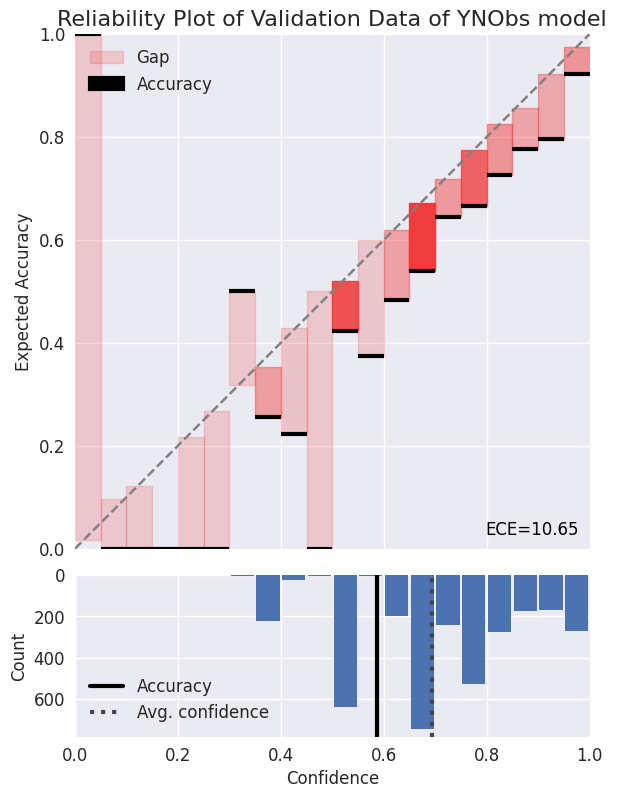

In [18]:


# on another dataset like nested
# if there is an error like: TypeError: only integer scalar arrays can be converted to a scalar index -- it's bc the inputs need to be np arrays NOT lists!
title = f"Reliability Plot of Training Data for all data"
# note! Not calibrating off training data but just to see that model is underconfident -- but val will be overconfident, so adjusting/calbrating off val is necessary


title = f"Reliability Plot of Validation Data of YNObs model"
# note! Not calibrating off training data but just to see that model is underconfident -- but val will be overconfident, so adjusting/calbrating off val is necessary
fig, ece = reliability_diagram(trueclass, predclass, predproba, num_bins=20, draw_ece=True, draw_bin_importance="alpha", draw_averages=True, title=title, figsize=(6, 6), dpi=100, return_fig=False)

In [16]:
########### Make plot
# plt.ioff()  # Turn off interactive mode. Need to reset kernel if do want to see them again 


# on another dataset like nested
# if there is an error like: TypeError: only integer scalar arrays can be converted to a scalar index -- it's bc the inputs need to be np arrays NOT lists!
title = f"Reliability Plot of Training Data for all data"
# note! Not calibrating off training data but just to see that model is underconfident -- but val will be overconfident, so adjusting/calbrating off val is necessary


title = f"Reliability Plot of Validation Data of YNObs model"
# note! Not calibrating off training data but just to see that model is underconfident -- but val will be overconfident, so adjusting/calbrating off val is necessary
fig, ece = reliability_diagram(trueclass, predclass, predproba, num_bins=20, draw_ece=True, draw_bin_importance="alpha", draw_averages=True, title=title, figsize=(6, 6), dpi=100, return_fig=False)

/tmp/tmp.1sbmA4rHB3/ipykernel_3993001/117717568.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


Evaluate - plot reliability curves example of how to run (for after data is loaded)
- this plots one of them
- to loop through and load many plots see below the data loading from OT

In [15]:
########### Make plot
plt.ioff()  # Turn off interactive mode. Need to reset kernel if do want to see them again 


# on another dataset like nested
# if there is an error like: TypeError: only integer scalar arrays can be converted to a scalar index -- it's bc the inputs need to be np arrays NOT lists!
title = f"Reliability Plot of Training Data for all data"
# note! Not calibrating off training data but just to see that model is underconfident -- but val will be overconfident, so adjusting/calbrating off val is necessary


title = f"Reliability Plot of Validation Data of YNObs model"
# note! Not calibrating off training data but just to see that model is underconfident -- but val will be overconfident, so adjusting/calbrating off val is necessary
fig, ece = reliability_diagram(trueclass, predclass, predproba, num_bins=20, draw_ece=True, draw_bin_importance="alpha", draw_averages=True, title=title, figsize=(6, 6), dpi=100, return_fig=False)



/tmp/tmp.1sbmA4rHB3/ipykernel_3993001/117717568.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


For ynobs

10888
Index(['Unnamed: 0.1', 'level_0', 'Unnamed: 0', 'index', 'img_name', 'site',
       'img_index', 'foldnum', 'ID', 'Latitude', 'Longitude', 'date', 'yr',
       'mo', 'day', 'time', 'yr_mo', 'timeofday', 'timeofevent', 'img_orig',
       'img_cat', 'foldnum_ynobs', 'foldnum_nested', 'in_ynobs', 'index.1',
       'A_prob_nonobs', 'A_prob_obs', 'A_model_pred', 'A_predprob',
       'B_prob_nonobs', 'B_prob_obs', 'B_model_pred', 'B_predprob',
       'C_prob_nonobs', 'C_prob_obs', 'C_model_pred', 'C_predprob',
       'D_prob_nonobs', 'D_prob_obs', 'D_model_pred', 'D_predprob',
       'E_prob_nonobs', 'E_prob_obs', 'E_model_pred', 'E_predprob',
       's_prob_nonobs', 's_prob_obs', 's_model_pred', 's_predprob',
       'list_5preds', 'list_5probs', 'dict_catAsKeys_modelAsValues',
       'dict_catAsKeys_countAsValues', 'dict_catAsKeys_probsAsValues',
       'dict_mostConfident_singleModel', 'ensembleAvg_obs',
       'ensembleAvg_nonobs', 'ensembleAvg_pred', 'ensembleAvg_predprob',
       

/tmp/tmp.ZkDhD0h7Jz/ipykernel_1845579/117717568.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


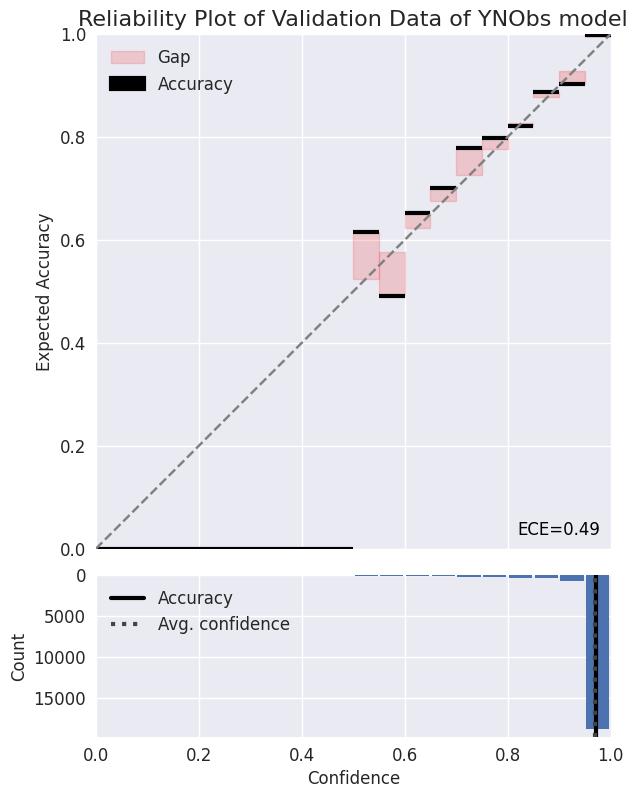

In [3]:


d1 = pd.read_csv("/home/csutter/DRIVE/dot/nested_results/2cat_ynobs/ensemble/ynobs_allVal_ensemble_OT0.csv")
# pd.read_csv("/home/csutter/DRIVE/dot/nested_results/2cat_ynobs/ensemble/ynobs_outside_ensemble_OT0.csv")
# pd.read_csv("/home/csutter/DRIVE/dot/model_trackpaths_results/ynobs_E_split0.csv")
print(len(d1))
print(d1.columns)

d2 = pd.read_csv("/home/csutter/DRIVE/dot/nested_results/2cat_ynobs/ensemble/ynobs_allVal_ensemble_OT1.csv")
# pd.read_csv("/home/csutter/DRIVE/dot/nested_results/2cat_ynobs/ensemble/ynobs_outside_ensemble_OT1.csv")
# pd.read_csv("/home/csutter/DRIVE/dot/model_trackpaths_results/ynobs_E_split0_results.csv")
print(len(d2))
print(d2.columns)

# # if want to merge them (for adding phase, ignore this)
# d = d1.merge(d2[["img_name","phase"]], how = "outer")

# # if want to combine
dplot = pd.concat([d1,d2], ignore_index=True)
# d = d.reset_index()

# # # if want to use just one at a time
# d = d2

dplot['predprob'] = dplot[['ensembleAvg_nonobs', 'ensembleAvg_obs']].max(axis=1)
print('here')

print("here!!")
print(len(dplot))
# d['phase'] = d['phase'].fillna('notused') # if have phase, which we dont for the ensembling one, but those ensemnling resulst we saved out are ALREADY just validation only

# to plot 5cat data
# dplot = d[d["phase"]=="notused"]
# to plot val data
# dplot = d[d["phase"]=="val"] # if have phase, which we dont for the ensembling one, but those ensemnling resulst we saved out are ALREADY just validation only


# dplot = dplot.reset_index()

trueclass = dplot["img_cat"]
predclass = dplot["select"]
predproba = dplot["ensembleAvg_predprob"]


# on another dataset like nested
# if there is an error like: TypeError: only integer scalar arrays can be converted to a scalar index -- it's bc the inputs need to be np arrays NOT lists!
title = f"Reliability Plot of Validation Data of YNObs model"
# note! Not calibrating off training data but just to see that model is underconfident -- but val will be overconfident, so adjusting/calbrating off val is necessary
fig, ece = reliability_diagram(trueclass, predclass, predproba, num_bins=20, draw_ece=True, draw_bin_importance="alpha", draw_averages=True, title=title, figsize=(6, 6), dpi=100, return_fig=False)


In [12]:
print(len(d))
print(len(dplot))

176
176


Try calibrating across an OT only (to have more data)
- Justify this by seeing that all the individual ones within an OT are all *generally* the same direction w/ over or under confident. 

See if the streamlined way of doing RF is actually calibrating it by plotting and checking ECE of 1) CNN alone 2) the streamlined RF and 3) the calibrated CNNs (which were already ran for the 3-step blending approach)

General approach:

- list ECEs of each of the 30, and for models 1 2 and 3
-  then compare for each of the three lists of 30, count how many of the 30 were higher in model 1 vs 2 vs 3. Can also aggregated by summing ECEs to get that stat
- it is copy and paste code for each

In [ ]:
# TO NOT SEE THE PLOTS

plt.ioff()  # Turn off interactive mode. Need to reset kernel if do want to see them again 

Note there are three chunks doing the same thing for different model variations, t1, t2, t3 !

In [ ]:
t1 = []

dir = "/home/csutter/DRIVE/dot/model_trackpaths_results"

files = os.listdir(dir)
    # print(files)
trackers1 = [f for f in files if ".csv" in f]
trackers2 = [f for f in trackers1 if "nestcv" in f]
trackers = sorted(trackers2)

for i in range(0,len(trackers)): # len(trackers)
    print(i)
    d = pd.read_csv(f"{dir}/{trackers[i]}")
    # d.head(4)
    # print(d.columns)

    d = d[d["outerPhase"]=="outerTest"].reset_index()
    # print(len(d))
    # from that analysis, see what's worth plotting to SHOW how it does/doesn't do calibration

    d['predprob'] = d[['prob_dry',
       'prob_poor_viz', 'prob_snow', 'prob_snow_severe', 'prob_wet']].max(axis=1)

    trueclass = d["img_cat"]
    predclass = d["model_pred"]
    predproba = d["predprob"]


    # on another dataset like nested
    # if there is an error like: TypeError: only integer scalar arrays can be converted to a scalar index -- it's bc the inputs need to be np arrays NOT lists!
    title = f"Reliability Plot of Training Data for all data"
    # note! Not calibrating off training data but just to see that model is underconfident -- but val will be overconfident, so adjusting/calbrating off val is necessary
    fig, ece = reliability_diagram(trueclass, predclass, predproba, num_bins=20, draw_ece=True, draw_bin_importance="alpha", draw_averages=True, title=title, figsize=(6, 6), dpi=100, return_fig=False)

    # print(type(fig))

    # print(ece)

    t1.append(ece)


In [ ]:
t2 = []
t2_innerTest = [] # also wanted to compare these to the other phases
t2_innerVal = []


##### for model 2 - streamline final

dir = "/home/csutter/DRIVE/dot/models_streamline/final"

files = os.listdir(dir)
    # print(files)
trackers = [f for f in files if ".csv" in f]
trackers = sorted(trackers)

for i in range(0,len(trackers)): # len(trackers)
    d = pd.read_csv(f"{dir}/{trackers[i]}")
    d.head(4)

    d = d[d["outerPhase"]=="outerTest"].reset_index()
    # print(len(d))
    # from that analysis, see what's worth plotting to SHOW how it does/doesn't do calibration

    trueclass = d["img_cat"]
    predclass = d["finalprediction"]
    predproba = d["finalprob"]


    # on another dataset like nested
    # if there is an error like: TypeError: only integer scalar arrays can be converted to a scalar index -- it's bc the inputs need to be np arrays NOT lists!
    title = f"Reliability Plot of Training Data for all data"
    # note! Not calibrating off training data but just to see that model is underconfident -- but val will be overconfident, so adjusting/calbrating off val is necessary
    fig, ece = reliability_diagram(trueclass, predclass, predproba, num_bins=20, draw_ece=True, draw_bin_importance="alpha", draw_averages=True, title=title, figsize=(6, 6), dpi=100, return_fig=False)

    # print(type(fig))

    # print(ece)

    t2.append(ece)


for i in range(0,len(trackers)): # len(trackers)
    d = pd.read_csv(f"{dir}/{trackers[i]}")
    d.head(4)

    d = d[d["innerPhase"]=="innerTest"].reset_index()
    # print(len(d))
    # from that analysis, see what's worth plotting to SHOW how it does/doesn't do calibration

    trueclass = d["img_cat"]
    predclass = d["finalprediction"]
    predproba = d["finalprob"]


    # on another dataset like nested
    # if there is an error like: TypeError: only integer scalar arrays can be converted to a scalar index -- it's bc the inputs need to be np arrays NOT lists!
    title = f"Reliability Plot of Training Data for all data"
    # note! Not calibrating off training data but just to see that model is underconfident -- but val will be overconfident, so adjusting/calbrating off val is necessary
    fig, ece = reliability_diagram(trueclass, predclass, predproba, num_bins=20, draw_ece=True, draw_bin_importance="alpha", draw_averages=True, title=title, figsize=(6, 6), dpi=100, return_fig=False)

    # print(type(fig))

    # print(ece)

    t2_innerTest.append(ece)



for i in range(0,len(trackers)): # len(trackers)
    d = pd.read_csv(f"{dir}/{trackers[i]}")
    d.head(4)

    d = d[d["innerPhase"]=="innerVal"].reset_index()
    # print(len(d))
    # from that analysis, see what's worth plotting to SHOW how it does/doesn't do calibration

    trueclass = d["img_cat"]
    predclass = d["finalprediction"]
    predproba = d["finalprob"]


    # on another dataset like nested
    # if there is an error like: TypeError: only integer scalar arrays can be converted to a scalar index -- it's bc the inputs need to be np arrays NOT lists!
    title = f"Reliability Plot of Training Data for all data"
    # note! Not calibrating off training data but just to see that model is underconfident -- but val will be overconfident, so adjusting/calbrating off val is necessary
    fig, ece = reliability_diagram(trueclass, predclass, predproba, num_bins=20, draw_ece=True, draw_bin_importance="alpha", draw_averages=True, title=title, figsize=(6, 6), dpi=100, return_fig=False)

    # print(type(fig))

    # print(ece)

    t2_innerVal.append(ece)

In [ ]:
d.columns

In [ ]:
t3 = []



##### for model 2 - streamline final

dir = "/home/csutter/DRIVE/dot/model_calibration/nestedcv/CNN"

files = os.listdir(dir)
    # print(files)
trackers = [f for f in files if ".csv" in f]
trackers = sorted(trackers)

for i in range(0,len(trackers)): # len(trackers)
    d = pd.read_csv(f"{dir}/{trackers[i]}")
    d.head(4)
    # print(d.columns)

    d = d[d["outerPhase"]=="outerTest"].reset_index()
    # print(len(d))
    # from that analysis, see what's worth plotting to SHOW how it does/doesn't do calibration

    trueclass = d["img_cat"]
    predclass = d["norm_calib_cat"]
    predproba = d["norm_calib_prob"]


    # on another dataset like nested
    # if there is an error like: TypeError: only integer scalar arrays can be converted to a scalar index -- it's bc the inputs need to be np arrays NOT lists!
    title = f"Reliability Plot of Training Data for all data"
    # note! Not calibrating off training data but just to see that model is underconfident -- but val will be overconfident, so adjusting/calbrating off val is necessary
    fig, ece = reliability_diagram(trueclass, predclass, predproba, num_bins=20, draw_ece=True, draw_bin_importance="alpha", draw_averages=True, title=title, figsize=(6, 6), dpi=100, return_fig=False)

    # print(type(fig))

    # print(ece)

    t3.append(ece)

In [ ]:
print(sum(t1))
print(np.mean(t1))

In [ ]:
print(sum(t2))
print(np.mean(t2))

In [ ]:
print(sum(t3))
print(np.mean(t3))

In [ ]:
print(sum(t2))
print(np.mean(t2))

In [ ]:
print(sum(t2_innerTest))
print(np.mean(t2_innerTest))

In [ ]:
print(sum(t2_innerVal))
print(np.mean(t2_innerVal))

calib of CNN check

In [ ]:
stream_raw = []

##### for model 2 - streamline final

dir = "/home/csutter/DRIVE/dot/model_calibration/nestedcv/CNN"

files = os.listdir(dir)
    # print(files)
trackers = [f for f in files if ".csv" in f]
trackers = sorted(trackers)

for i in range(0,len(trackers)): # len(trackers)
    d = pd.read_csv(f"{dir}/{trackers[i]}")
    d.head(4)

    d = d[d["outerPhase"]=="outerTest"].reset_index()
    # print(len(d))
    # from that analysis, see what's worth plotting to SHOW how it does/doesn't do calibration

    cols_to_max = ['prob_dry','prob_poor_viz', 'prob_snow', 'prob_snow_severe', 'prob_wet']
    d["model_prob"] = d[cols_to_max].max(axis=1)

    # for uncalibrated
    trueclass = d["img_cat"]
    predclass = d["model_pred"]
    predproba = d["model_prob"]

    # for calibrated
    # trueclass = d["img_cat"]
    # predclass = d["norm_calib_cat"]
    # predproba = d["norm_calib_prob"]


    # on another dataset like nested
    # if there is an error like: TypeError: only integer scalar arrays can be converted to a scalar index -- it's bc the inputs need to be np arrays NOT lists!
    title = f"Reliability Plot of Training Data for all data"
    # note! Not calibrating off training data but just to see that model is underconfident -- but val will be overconfident, so adjusting/calbrating off val is necessary
    fig, ece = reliability_diagram(trueclass, predclass, predproba, num_bins=20, draw_ece=True, draw_bin_importance="alpha", draw_averages=True, title=title, figsize=(6, 6), dpi=100, return_fig=False)

    # print(type(fig))

    # print(ece)

    stream_raw.append(ece)



In [ ]:
d.head(4)

In [ ]:
d.columns

check streamline calibration: raw streamline, streamline with calib og way (by each class), streamlined with calib on pred cat only

In [ ]:
stream_raw = []

##### for model 2 - streamline final

dir = "/home/csutter/DRIVE/dot/models_streamline/final"

files = os.listdir(dir)
    # print(files)
trackers = [f for f in files if ".csv" in f]
trackers = sorted(trackers)

for i in range(0,len(trackers)): # len(trackers)
    d = pd.read_csv(f"{dir}/{trackers[i]}")
    d.head(4)

    d = d[d["outerPhase"]=="outerTest"].reset_index()
    # print(len(d))
    # from that analysis, see what's worth plotting to SHOW how it does/doesn't do calibration

    trueclass = d["img_cat"]
    predclass = d["finalprediction"]
    predproba = d["finalprob"]


    # on another dataset like nested
    # if there is an error like: TypeError: only integer scalar arrays can be converted to a scalar index -- it's bc the inputs need to be np arrays NOT lists!
    title = f"Reliability Plot of Training Data for all data"
    # note! Not calibrating off training data but just to see that model is underconfident -- but val will be overconfident, so adjusting/calbrating off val is necessary
    fig, ece = reliability_diagram(trueclass, predclass, predproba, num_bins=20, draw_ece=True, draw_bin_importance="alpha", draw_averages=True, title=title, figsize=(6, 6), dpi=100, return_fig=False)

    # print(type(fig))

    # print(ece)

    stream_raw.append(ece)



In [ ]:
stream_raw = []

##### for model 2 - streamline final

dir = "/home/csutter/DRIVE/dot/model_calibration/nestedcv/streamlined_TS"

files = os.listdir(dir)
    # print(files)
trackers = [f for f in files if ".csv" in f]
trackers = sorted(trackers)

for i in range(0,len(trackers)): # len(trackers)
    d = pd.read_csv(f"{dir}/{trackers[i]}")
    d.head(4)

    d = d[d["innerPhase"]=="innerTest"].reset_index()
    # print(len(d))
    # from that analysis, see what's worth plotting to SHOW how it does/doesn't do calibration

    trueclass = d["img_cat"]
    predclass = d["finalprediction"]
    predproba = d["finalprob"]


    # on another dataset like nested
    # if there is an error like: TypeError: only integer scalar arrays can be converted to a scalar index -- it's bc the inputs need to be np arrays NOT lists!
    title = f"Reliability Plot of Training Data for all data"
    # note! Not calibrating off training data but just to see that model is underconfident -- but val will be overconfident, so adjusting/calbrating off val is necessary
    fig, ece = reliability_diagram(trueclass, predclass, predproba, num_bins=20, draw_ece=True, draw_bin_importance="alpha", draw_averages=True, title=title, figsize=(6, 6), dpi=100, return_fig=False)

    # print(type(fig))

    # print(ece)

    stream_raw.append(ece)



In [ ]:
stream_raw = []

##### for model 2 - streamline final

dir = "/home/csutter/DRIVE/dot/models_streamline/final"

files = os.listdir(dir)
    # print(files)
trackers = [f for f in files if ".csv" in f]
trackers = sorted(trackers)

for i in range(0,1): # len(trackers)
    d = pd.read_csv(f"{dir}/{trackers[i]}")
    d.head(4)

    d = d[d["innerPhase"]=="innerTrain"].reset_index()
    # print(len(d))
    # from that analysis, see what's worth plotting to SHOW how it does/doesn't do calibration

    trueclass = d["img_cat"]
    predclass = d["finalprediction"]
    predproba = d["finalprob"]


    # on another dataset like nested
    # if there is an error like: TypeError: only integer scalar arrays can be converted to a scalar index -- it's bc the inputs need to be np arrays NOT lists!
    title = f"Reliability Plot of Training Data for all data"
    # note! Not calibrating off training data but just to see that model is underconfident -- but val will be overconfident, so adjusting/calbrating off val is necessary
    fig, ece = reliability_diagram(trueclass, predclass, predproba, num_bins=20, draw_ece=True, draw_bin_importance="alpha", draw_averages=True, title=title, figsize=(6, 6), dpi=100, return_fig=False)

    # print(type(fig))

    # print(ece)

    stream_raw.append(ece)



In [ ]:
stream_raw

In [ ]:
stream_caliborig = []

##### for model 2 - streamline final

dir = "/home/csutter/DRIVE/dot/model_calibration/nestedcv/streamlined"

files = os.listdir(dir)
    # print(files)
trackers = [f for f in files if ".csv" in f]
trackers = sorted(trackers)

for i in range(0,1): # len(trackers)
    d = pd.read_csv(f"{dir}/{trackers[i]}")
    d.head(4)

    d = d[d["innerPhase"]=="innerTrain"].reset_index()
    # print(len(d))
    # from that analysis, see what's worth plotting to SHOW how it does/doesn't do calibration

    trueclass = d["img_cat"]
    predclass = d["finalprediction"]
    predproba = d["finalprob"]


    # on another dataset like nested
    # if there is an error like: TypeError: only integer scalar arrays can be converted to a scalar index -- it's bc the inputs need to be np arrays NOT lists!
    title = f"Reliability Plot of Training Data for all data"
    # note! Not calibrating off training data but just to see that model is underconfident -- but val will be overconfident, so adjusting/calbrating off val is necessary
    fig, ece = reliability_diagram(trueclass, predclass, predproba, num_bins=20, draw_ece=True, draw_bin_importance="alpha", draw_averages=True, title=title, figsize=(6, 6), dpi=100, return_fig=False)

    # print(type(fig))

    # print(ece)

    stream_caliborig.append(ece)

# HERE:)

In [ ]:
stream_caliborig

/tmp/tmp.i9hZx6GQrN/ipykernel_1590640/117717568.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)
/tmp/tmp.i9hZx6GQrN/ipykernel_1590640/117717568.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)
/tmp/tmp.i9hZx6GQrN/ipykernel_1590640/117717568.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)
/tmp/tmp.i9hZx6GQrN/ipykernel_1590640/117717568.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)
/tmp/tmp.i9hZx6GQrN/ipykernel_1590640/117717568.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)
/tmp/tmp.i9hZx6GQrN/ipykernel_1590640/117717568.py:173: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)
/tmp

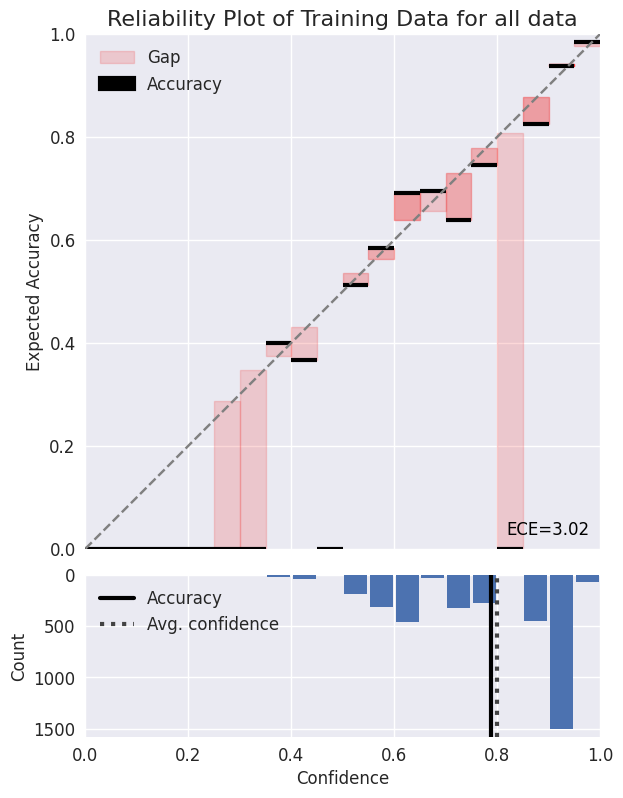

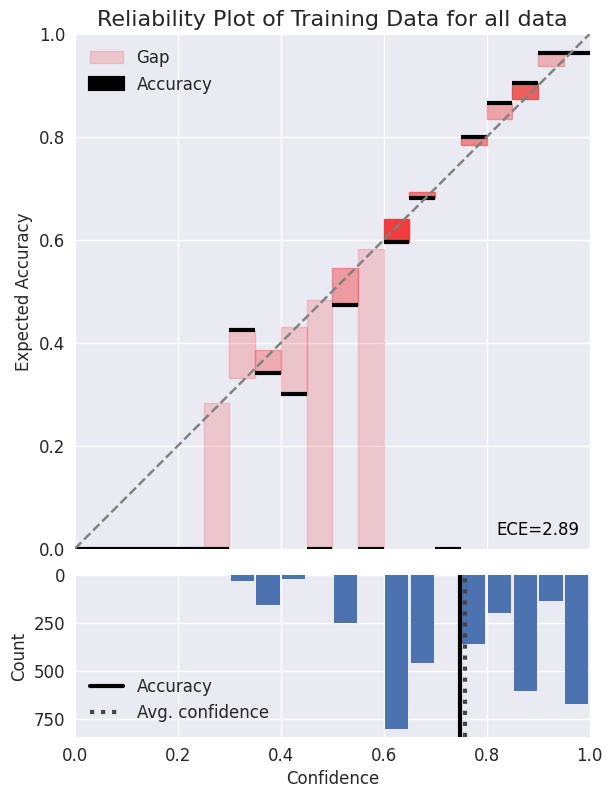

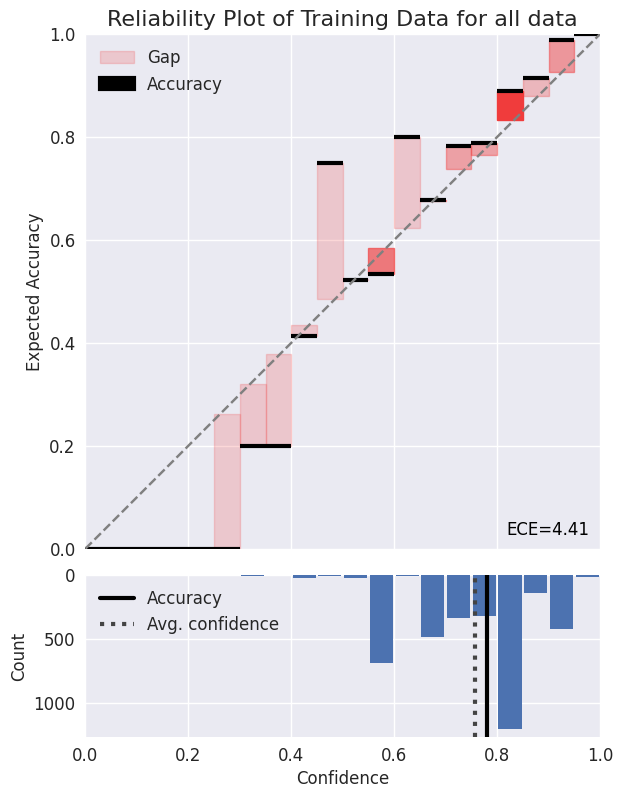

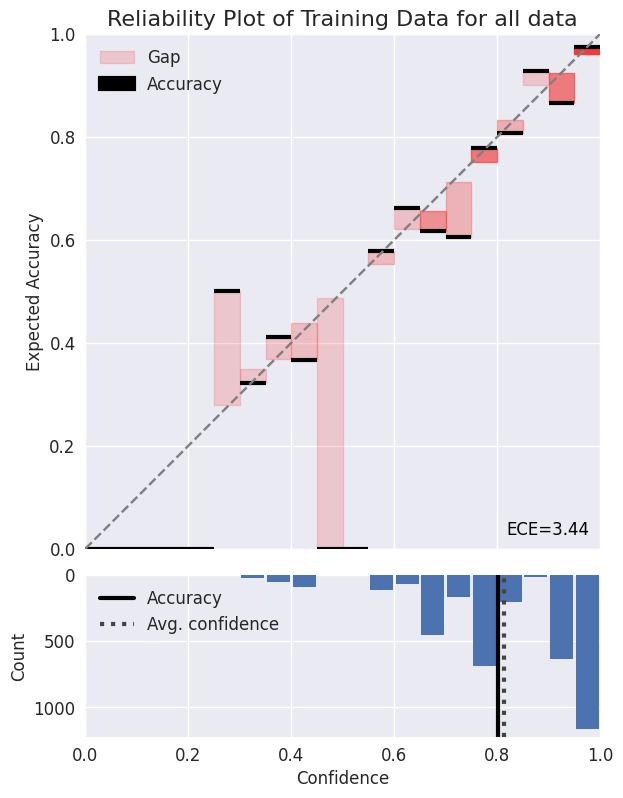

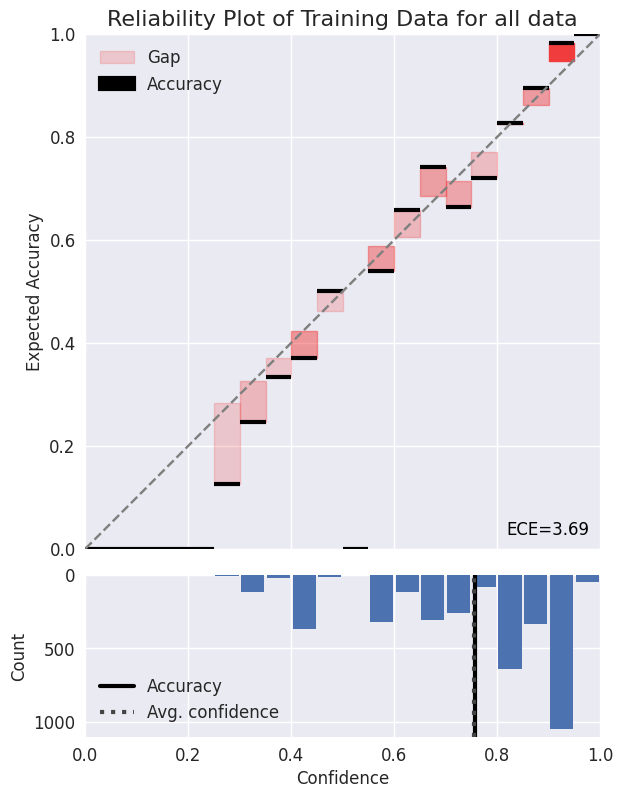

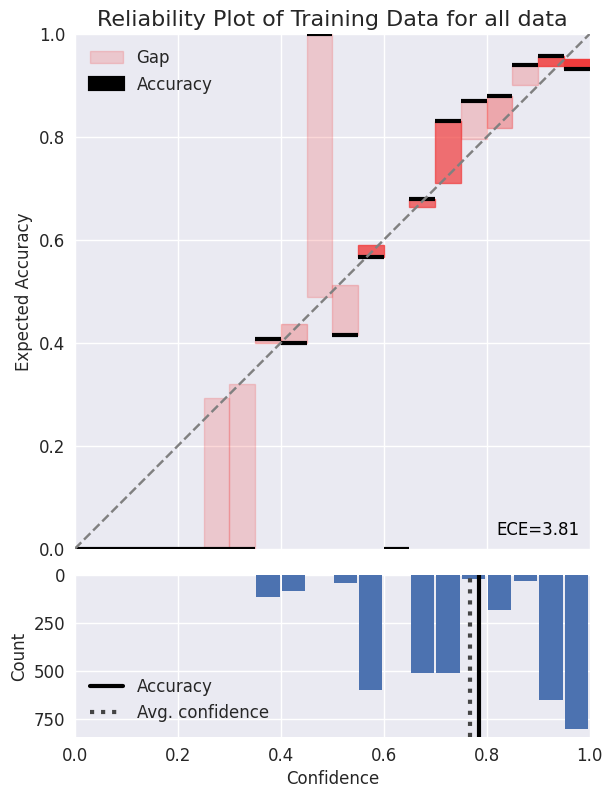

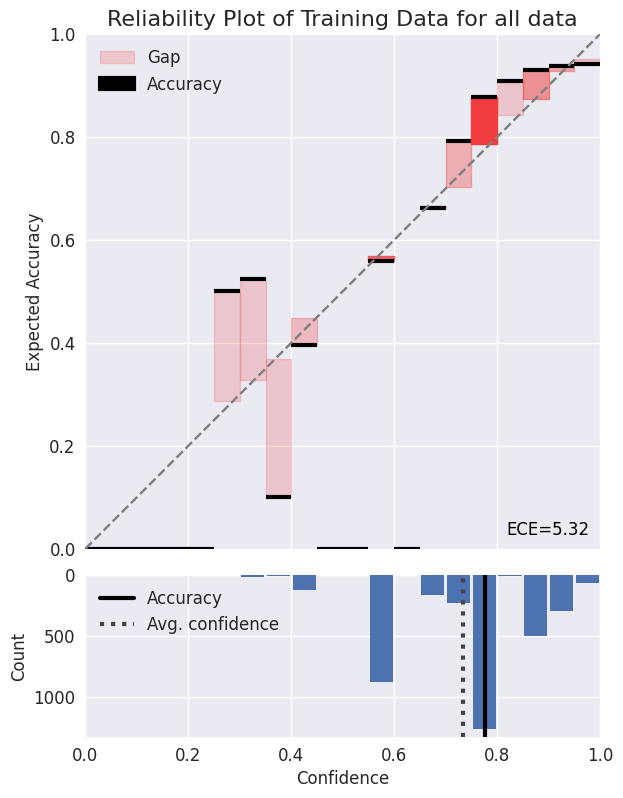

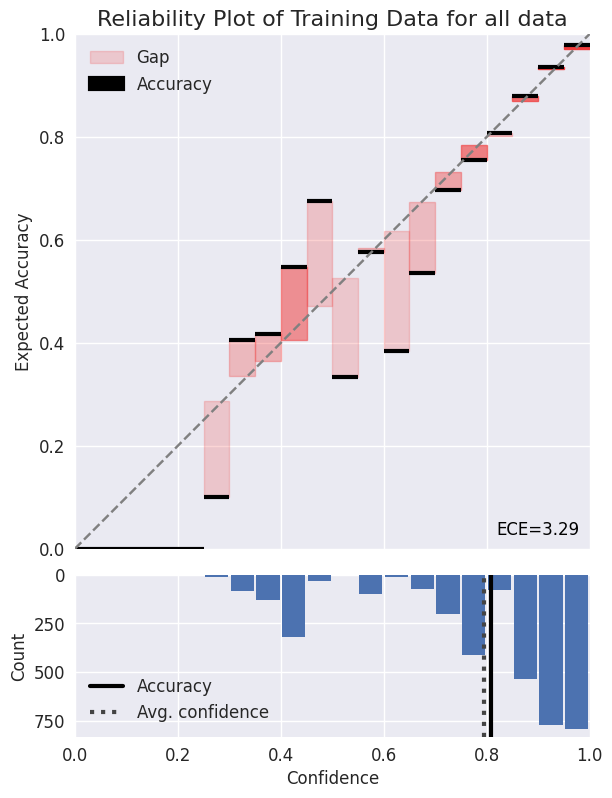

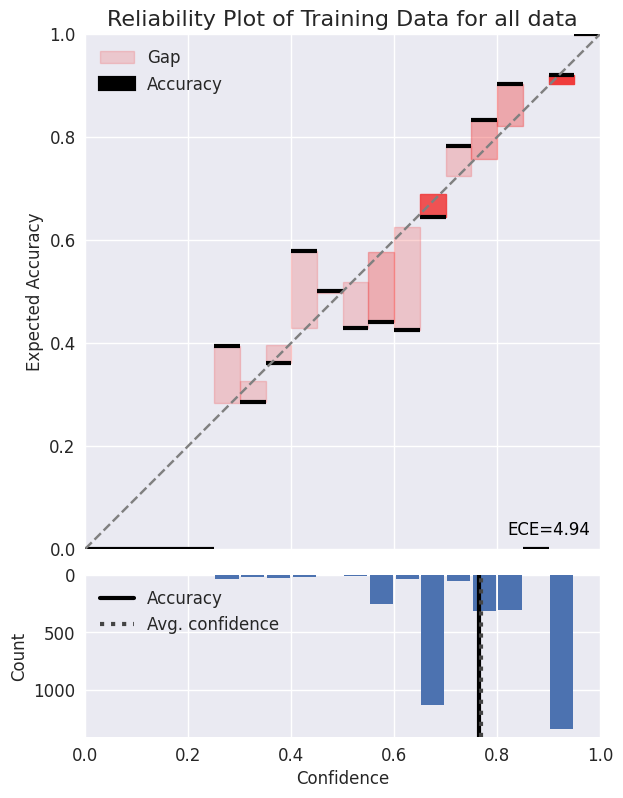

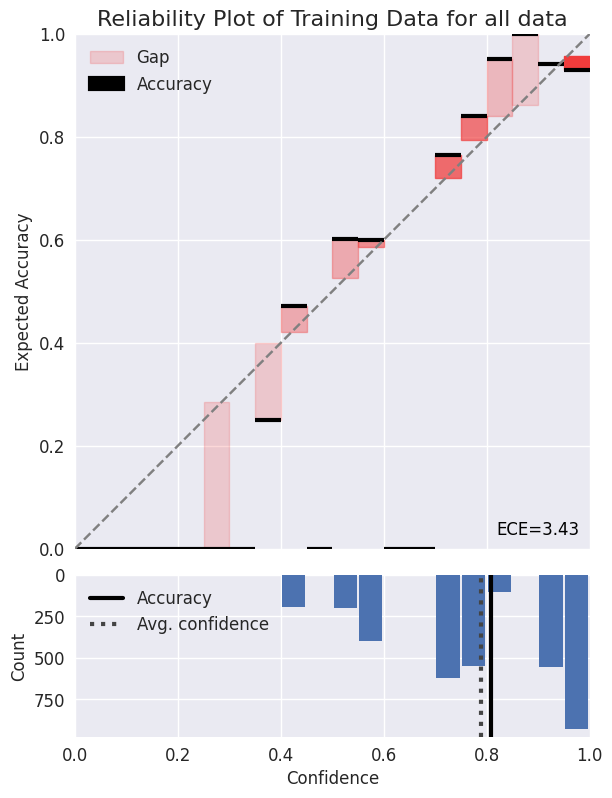

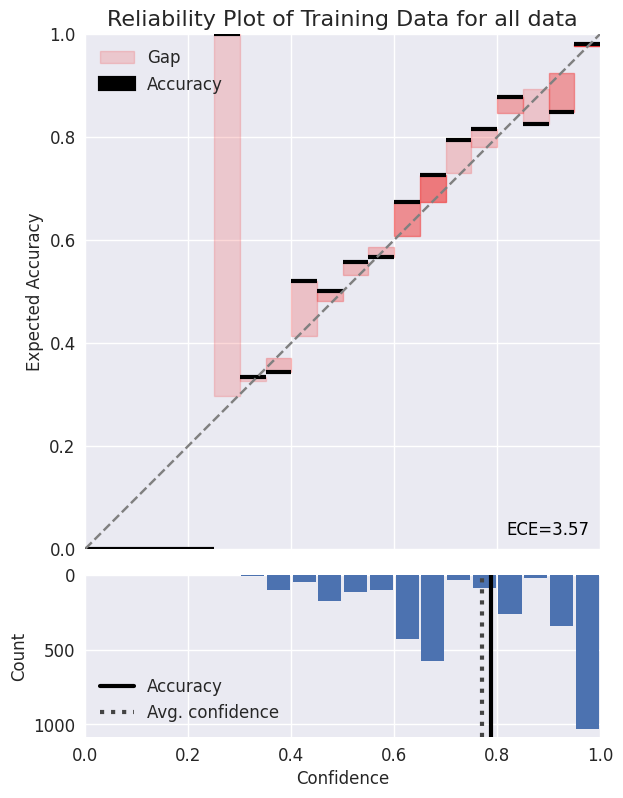

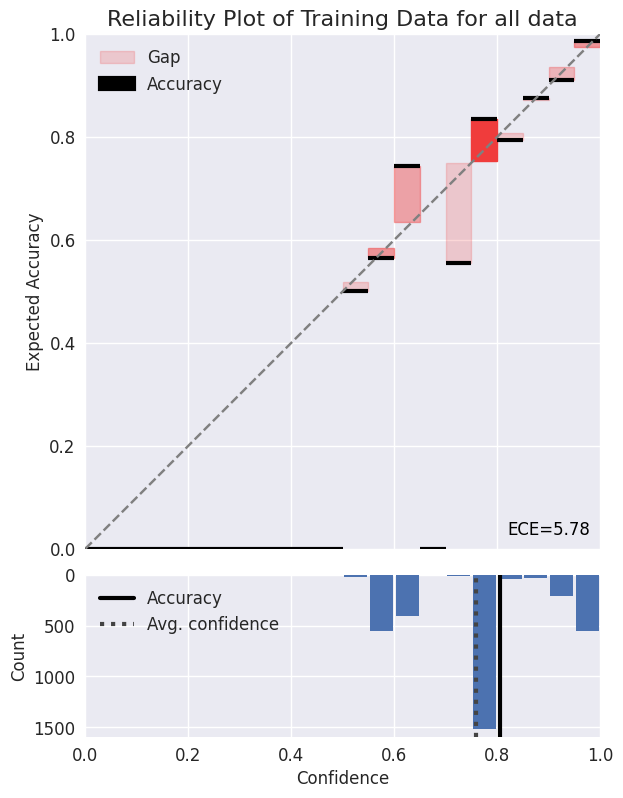

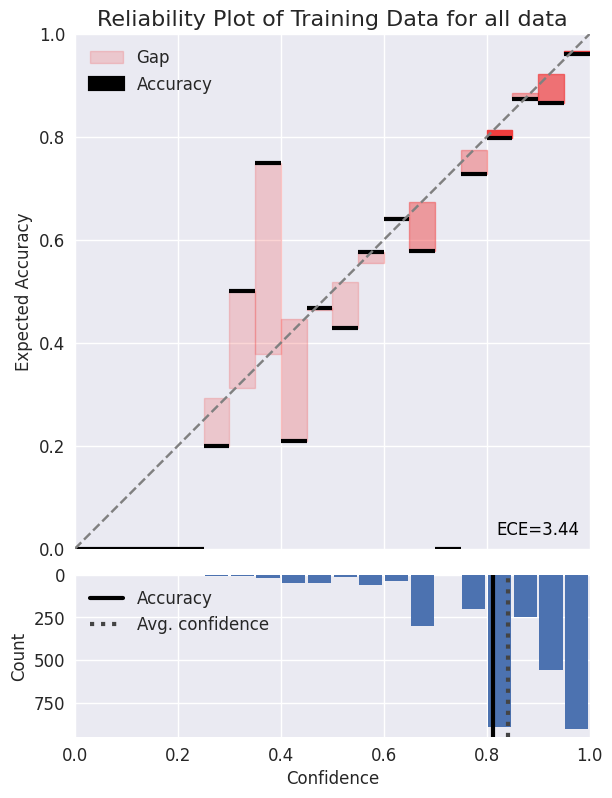

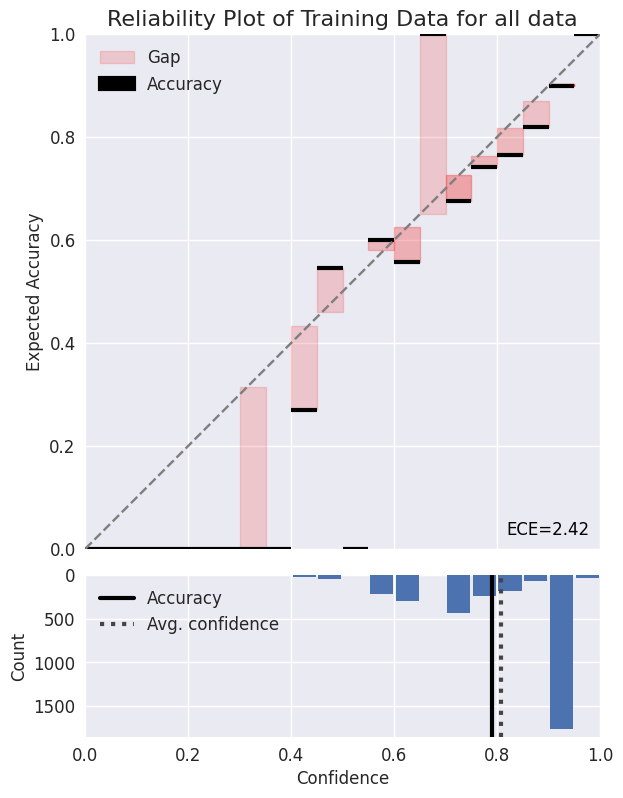

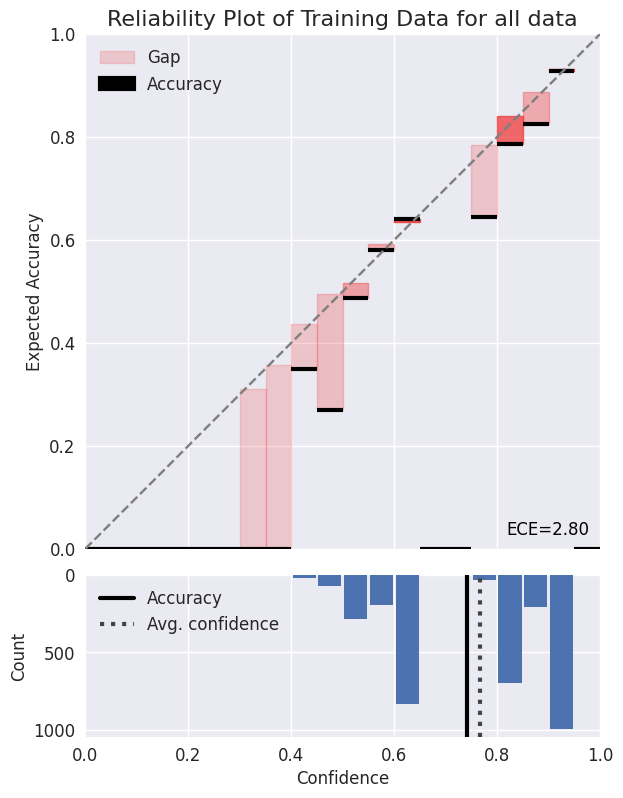

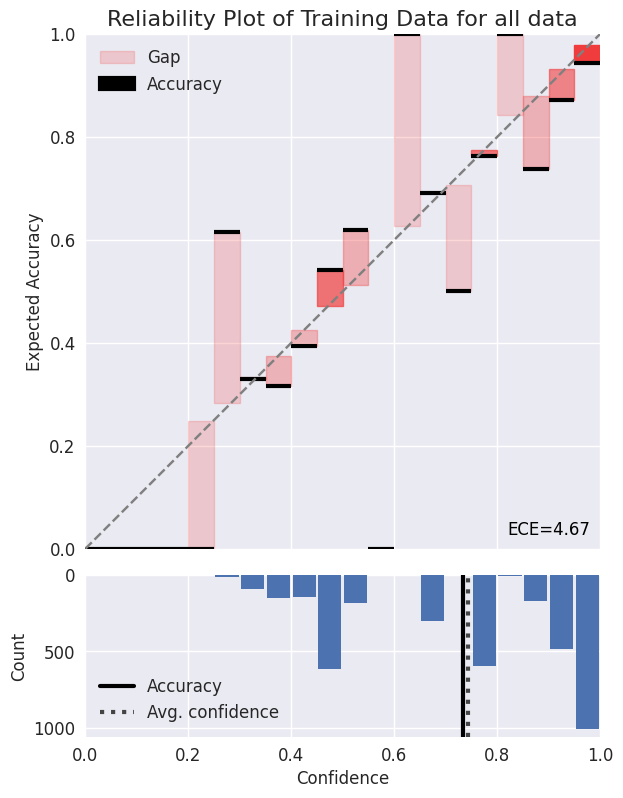

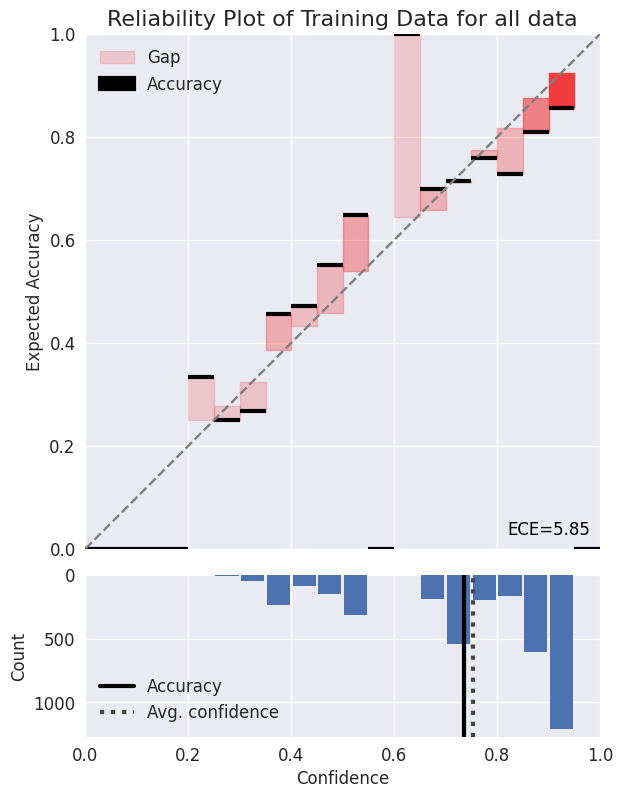

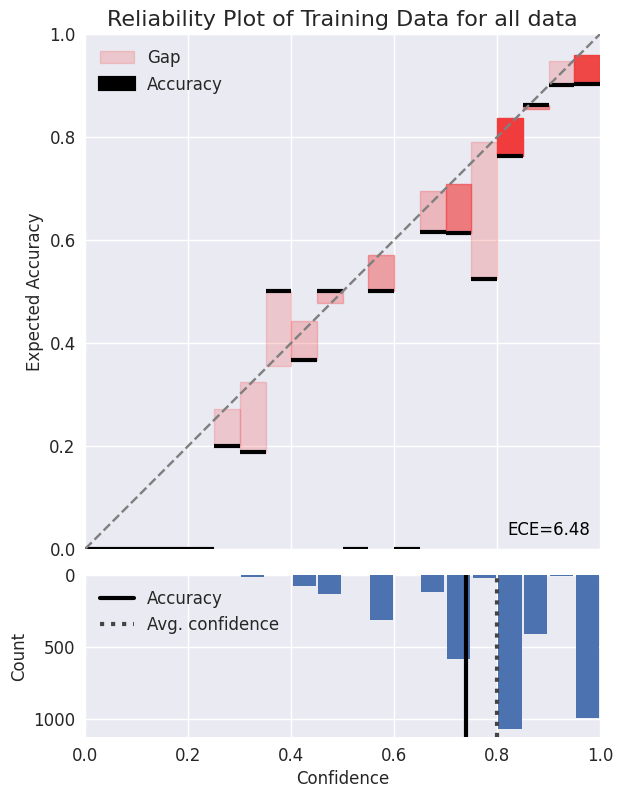

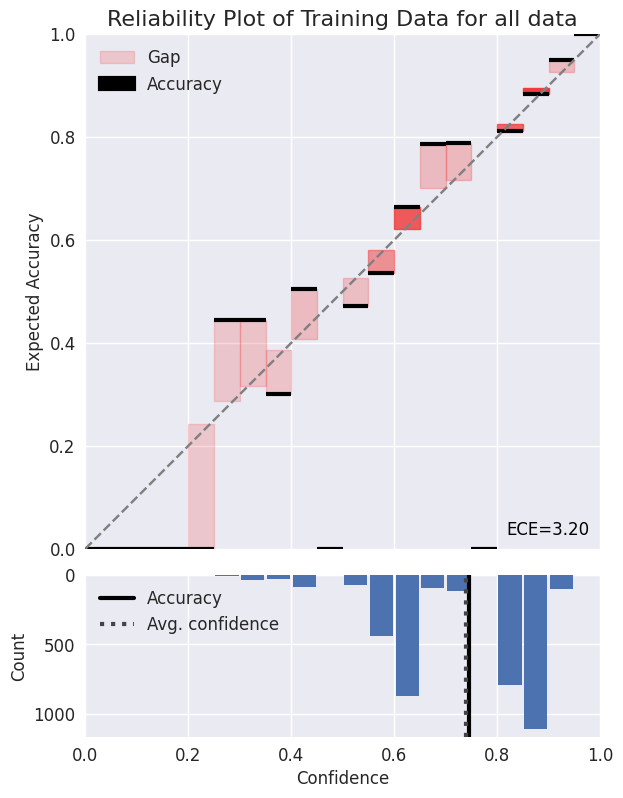

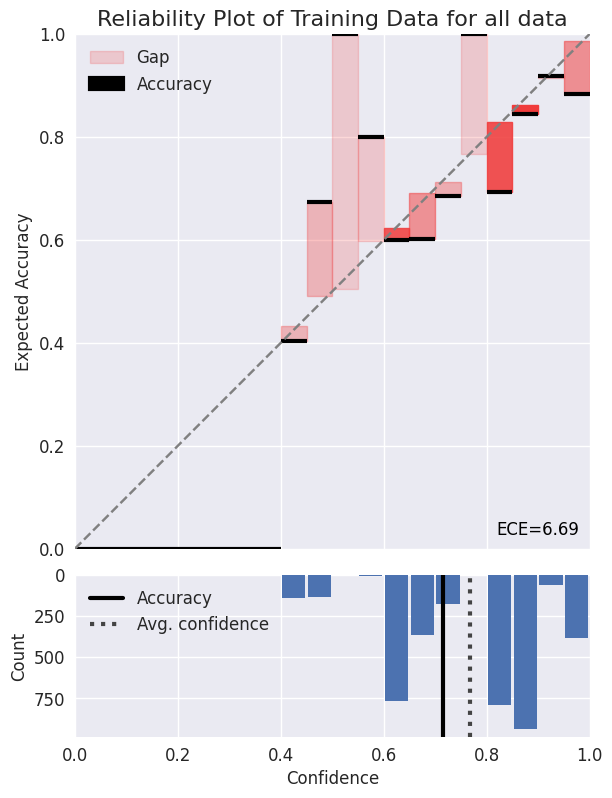

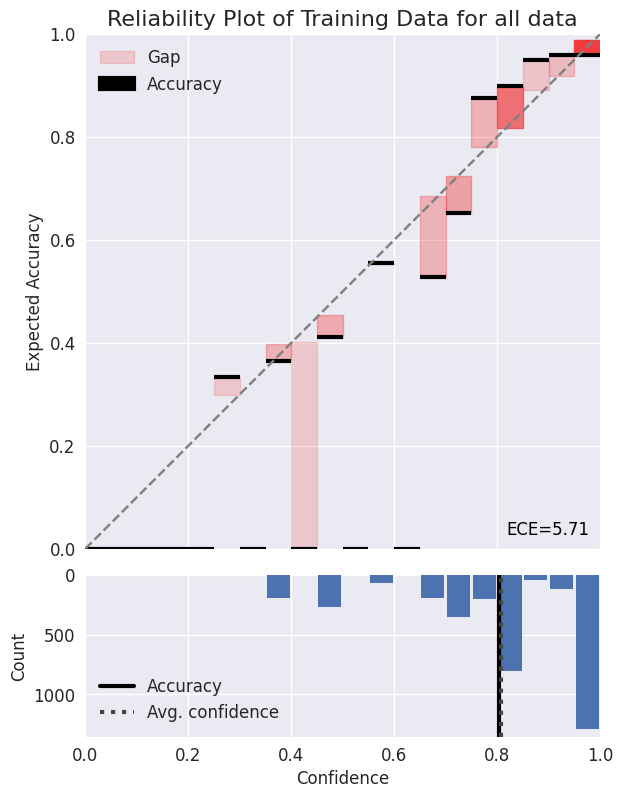

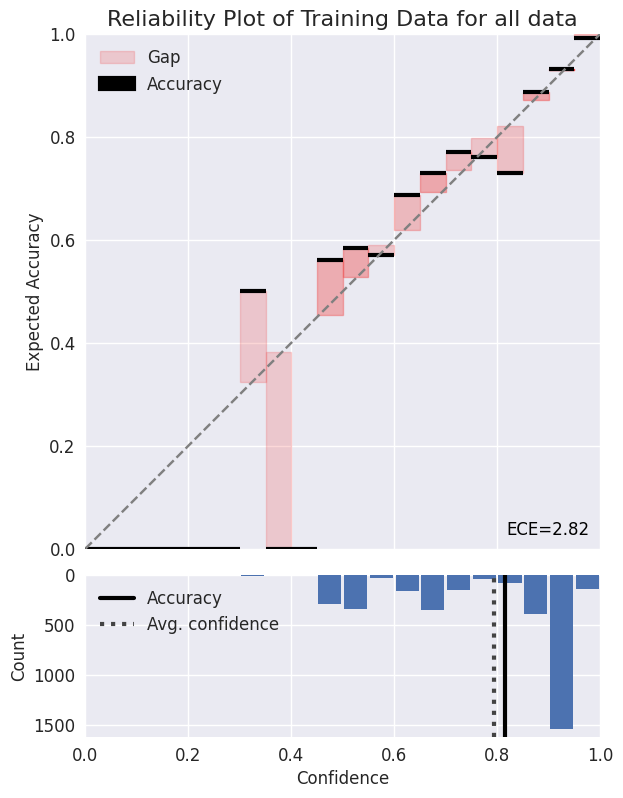

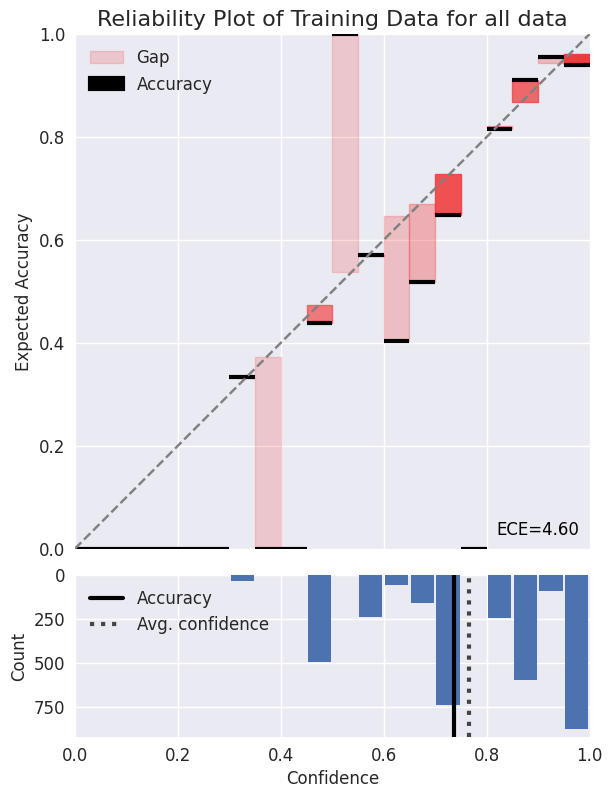

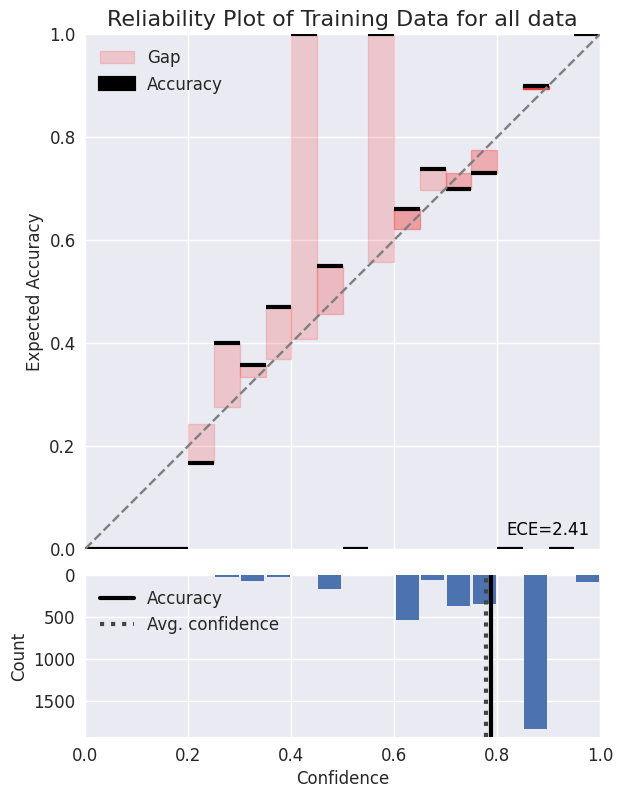

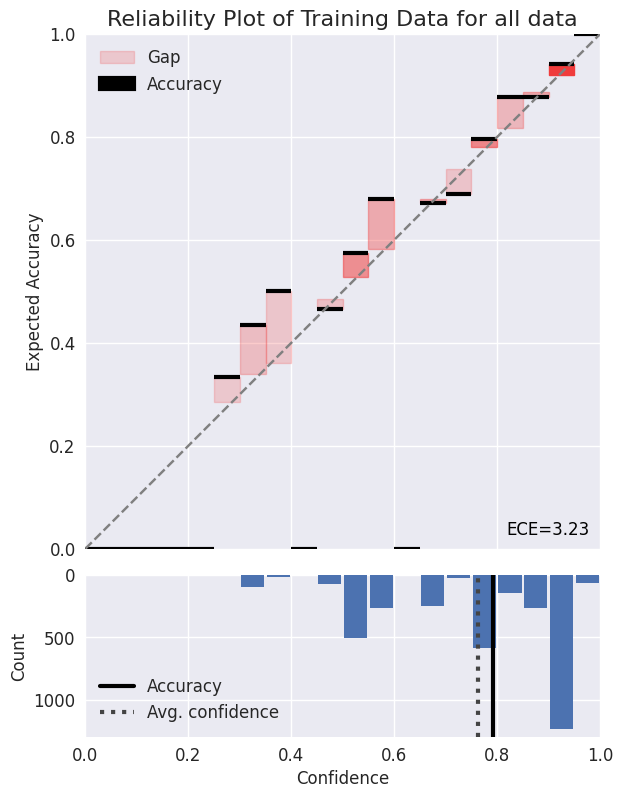

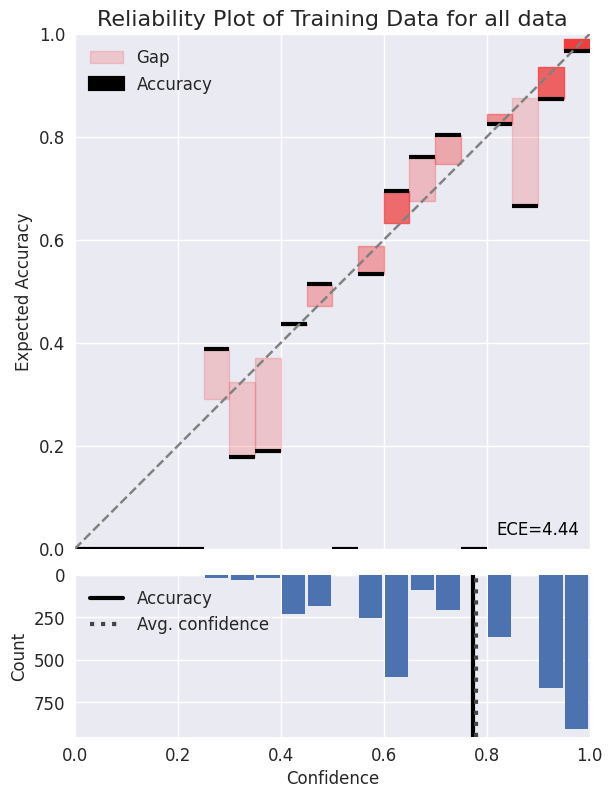

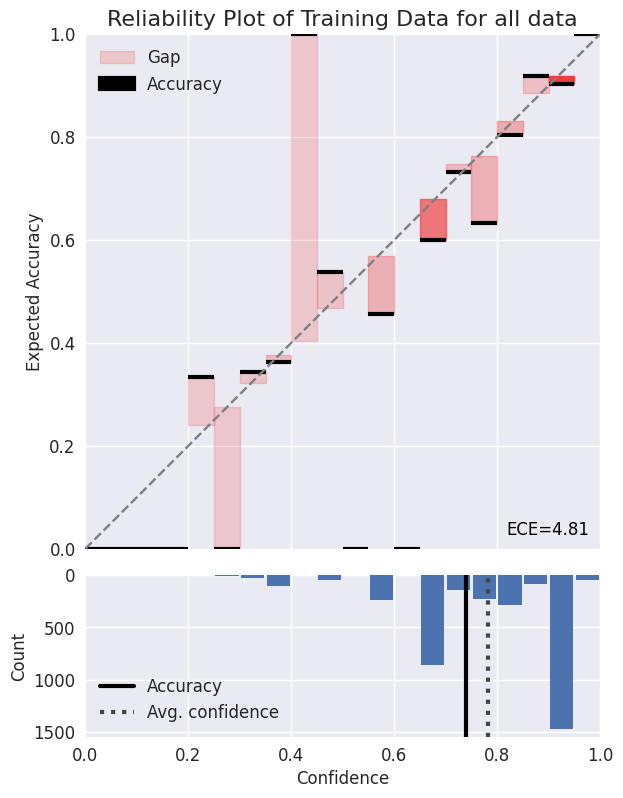

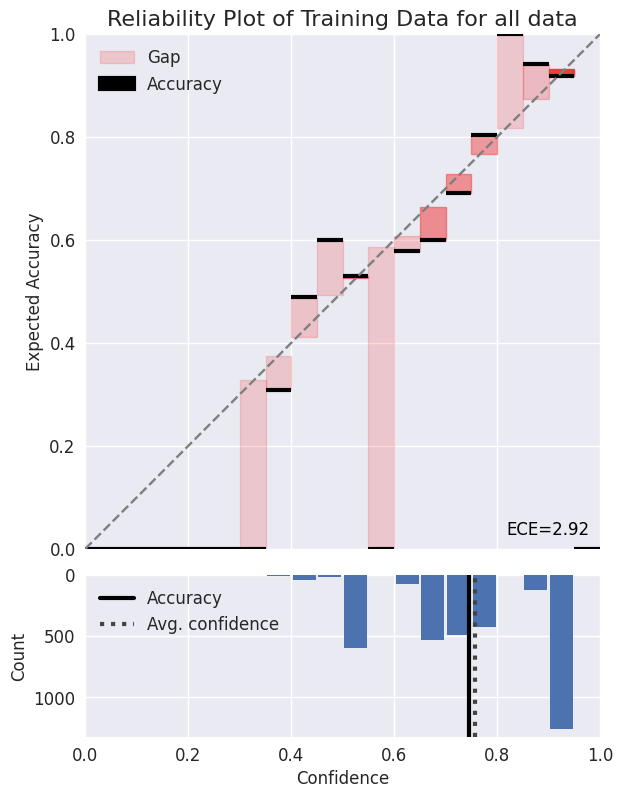

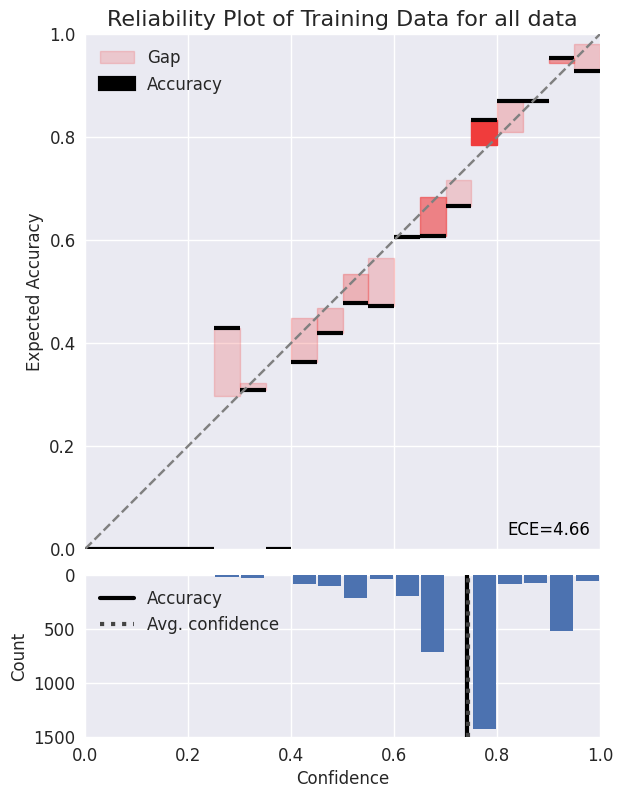

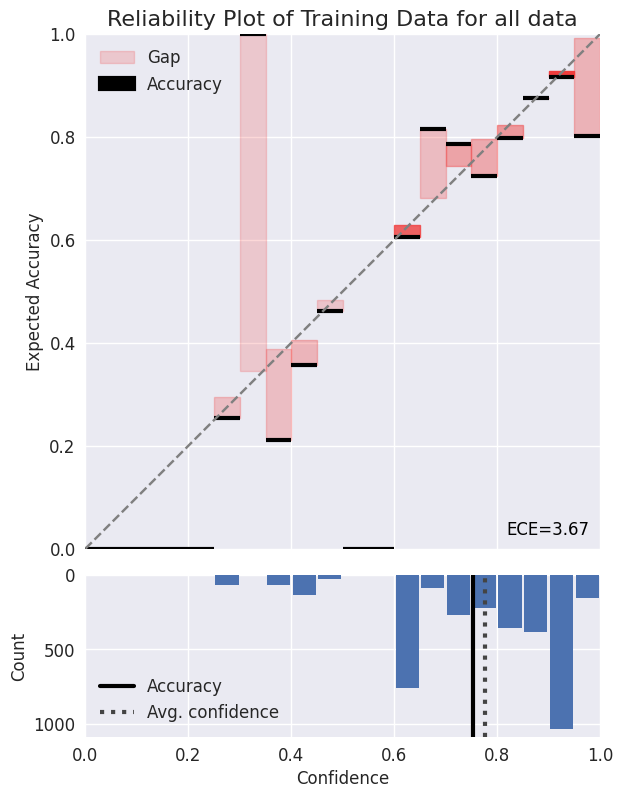

In [15]:
stream_calibPredOnly = []

##### for model 2 - streamline final

dir = "/home/csutter/DRIVE/dot/model_calibration/nestedcv/streamlined_calibPredOnly"

files = os.listdir(dir)
    # print(files)
trackers = [f for f in files if ".csv" in f]
trackers = sorted(trackers)

for i in range(0,len(trackers)): # len(trackers)
    d = pd.read_csv(f"{dir}/{trackers[i]}")
    d.head(4)

    d = d[d["outerPhase"]=="outerTest"].reset_index()
    # print(len(d))
    # from that analysis, see what's worth plotting to SHOW how it does/doesn't do calibration

    trueclass = d["img_cat"]
    predclass = d["finalprediction"]
    predproba = d["finalprob"]


    # on another dataset like nested
    # if there is an error like: TypeError: only integer scalar arrays can be converted to a scalar index -- it's bc the inputs need to be np arrays NOT lists!
    title = f"Reliability Plot of Training Data for all data"
    # note! Not calibrating off training data but just to see that model is underconfident -- but val will be overconfident, so adjusting/calbrating off val is necessary
    fig, ece = reliability_diagram(trueclass, predclass, predproba, num_bins=20, draw_ece=True, draw_bin_importance="alpha", draw_averages=True, title=title, figsize=(6, 6), dpi=100, return_fig=False)

    # print(type(fig))

    # print(ece)

    stream_calibPredOnly.append(ece)



In [ ]:
stream_calibPredWithinOT = []

##### for model 2 - streamline final

dir = "/home/csutter/DRIVE/dot/model_calibration/nestedcv/streamlined_acrossOT"

files = os.listdir(dir)
    # print(files)
trackers = [f for f in files if ".csv" in f]
trackers = sorted(trackers)

for i in range(0,len(trackers)): # len(trackers)
    d = pd.read_csv(f"{dir}/{trackers[i]}")
    d.head(4)

    d = d[d["outerPhase"]=="outerTest"].reset_index()
    # print(len(d))
    # from that analysis, see what's worth plotting to SHOW how it does/doesn't do calibration

    trueclass = d["img_cat"]
    predclass = d["finalprediction"]
    predproba = d["finalprob"]


    # on another dataset like nested
    # if there is an error like: TypeError: only integer scalar arrays can be converted to a scalar index -- it's bc the inputs need to be np arrays NOT lists!
    title = f"Reliability Plot of Training Data for all data"
    # note! Not calibrating off training data but just to see that model is underconfident -- but val will be overconfident, so adjusting/calbrating off val is necessary
    fig, ece = reliability_diagram(trueclass, predclass, predproba, num_bins=20, draw_ece=True, draw_bin_importance="alpha", draw_averages=True, title=title, figsize=(6, 6), dpi=100, return_fig=False)

    # print(type(fig))

    # print(ece)

    stream_calibPredWithinOT.append(ece)



To aggregate all test or OT data from across 5 models within one OT; essentially one plot per OT

In [ ]:
directory = "/home/csutter/DRIVE/dot/model_calibration/nestedcv/blending"
csv_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".csv")]

csv_files = sorted(csv_files)

OTnum = []
modelnum = []
ece_original = []
ece_calibrated = []

for i in [1]: # Change this to range(6) if want to plot all. O/w just make a list of like [2] if we want to see from OT2 only, for example
    print(f"On outertest {i}")
    OTnum.append(i)
    OTmodels = [x for x in csv_files if f"OT{i}" in x ]

    OT_aggdata_trueclass_original = []
    OT_aggdata_predclass_original = []
    OT_aggdata_predproba_original = []
    OT_aggdata_trueclass_calibrated = []
    OT_aggdata_predclass_calibrated = []
    OT_aggdata_predproba_calibrated = []
    for j in range(5):
        print(f"On model {j}")
        modelnum.append(j)
        modeluse= OTmodels[j]

        # prepare original uncalibrated data
        trueclass, predclass, predproba = load_data_fromblending(modeluse, usecalib=False)

        for k in range(0, len(trueclass)):
            OT_aggdata_trueclass_original.append(trueclass[k])
            OT_aggdata_predclass_original.append(predclass[k])
            OT_aggdata_predproba_original.append(predproba[k])
        
        
        # prepare calibrated data

        trueclass, predclass, predproba = load_data_fromblending(modeluse, usecalib=True)

        for k in range(0, len(trueclass)):
            OT_aggdata_trueclass_calibrated.append(trueclass[k])
            OT_aggdata_predclass_calibrated.append(predclass[k])
            OT_aggdata_predproba_calibrated.append(predproba[k])

    print("Uncalibrated (model's direct probability outputs)")

    # print(OT_aggdata_trueclass_original[0:5])
    # print(OT_aggdata_predclass_original[0:5])
    # print(OT_aggdata_predproba_original[0:5])
    fig, ece = reliability_diagram(np.array(OT_aggdata_trueclass_original), np.array(OT_aggdata_predclass_original), np.array(OT_aggdata_predproba_original), num_bins=20, draw_ece=True, draw_bin_importance="alpha", draw_averages=True, title=f"Case OuterTest{i} Aggregated Across 5 Models", figsize=(6,6), dpi=100) # Plot directly on the subplot

    fig, ece = reliability_diagram(np.array(OT_aggdata_trueclass_calibrated), np.array(OT_aggdata_predclass_calibrated), np.array(OT_aggdata_predproba_calibrated), num_bins=20, draw_ece=True, draw_bin_importance="alpha", draw_averages=True, title=f"Case OuterTest{i} Aggregated Across 5 Models - Calibrated", figsize=(6,6), dpi=100) # Plot directly on the subplot


In [ ]:
print(ece_original)

print(ece_calibrated)

Data loading - define functions

In [ ]:
# eventually loop through and do this for all plots: /home/csutter/DRIVE/dot/model_calibration/nestedcv/CNN -- but for now just do it with one as example to get working 

def load_data_fromcnn(dfpath, usecalib):

    dfdata = pd.read_csv(dfpath)

    # print(dfdata.columns)

    # add final (max) prob for both the cnn (uncalibrated) and calibrated

    dfdata["cnn_maxprob"] = dfdata[['prob_dry','prob_poor_viz', 'prob_snow','prob_snow_severe', 'prob_wet']].max(axis=1)

    dfdata["cnncalib_maxprob"] = dfdata[['norm_calib_dry', 'norm_calib_poor_viz',
    'norm_calib_snow', 'norm_calib_snow_severe', 'norm_calib_wet']].max(axis=1)

    # print(dfdata.columns)

    # print(np.unique(dfdata["innerPhase"]))

    train = dfdata[dfdata["innerPhase"]=="innerTrain"]
    val = dfdata[dfdata["innerPhase"]=="innerVal"]
    test = dfdata[dfdata["innerPhase"]=="innerTest"]
    OT = dfdata[dfdata["outerPhase"]=="outerTest"]

    print(len(train)+len(val)+len(test)+len(OT))
    print(len(dfdata))

    # will eventually need to subset by class if redoing the isotonic regression but for now just inspect reliability curves

    ##### for reliability plot: 

    trueclass = np.array(test["img_cat"])

    if usecalib: 
        ## to see calibrated model
        # print(trueclass[0:5])
        predclass = np.array(test["norm_calib_cat"])
        # print(predclass[0:5])
        predproba = np.array(test["cnncalib_maxprob"])
        # print(predproba[0:5])
    else:
        ## to see original uncalibrated version
        # for reliability plot: 
        trueclass = np.array(test["img_cat"])
        # print(trueclass[0:5])
        predclass = np.array(test["model_pred"])
        # print(predclass[0:5])
        predproba = np.array(test["cnn_maxprob"])
        # print(predproba[0:5])

    return trueclass, predclass, predproba

In [ ]:

def load_data_fromsvm(dfpath, usecalib):

    dfdata = pd.read_csv(dfpath)

    # print(dfdata.columns)

    # add final (max) prob for both the svm (uncalibrated) and calibrated

    dfdata["svm_maxprob"] = dfdata[['svm_prob_dry',
       'svm_prob_poor_viz', 'svm_prob_snow', 'svm_prob_snow_severe',
       'svm_prob_wet']].max(axis=1)

    dfdata["svmcalib_maxprob"] = dfdata[['norm_calib_dry', 'norm_calib_poor_viz',
    'norm_calib_snow', 'norm_calib_snow_severe', 'norm_calib_wet']].max(axis=1)

    # print(dfdata.columns)

    train = dfdata[dfdata["innerPhase"]=="innerTrain"]
    val = dfdata[dfdata["innerPhase"]=="innerVal"]
    test = dfdata[dfdata["innerPhase"]=="innerTest"]
    OT = dfdata[dfdata["innerPhase"]=="NAOuterTest"]

    print(len(train)+len(val)+len(test)+len(OT))
    print(len(dfdata))

    # will eventually need to subset by class if redoing the isotonic regression but for now just inspect reliability curves

    ##### for reliability plot: 

    trueclass = np.array(test["img_cat"])

    if usecalib: 
        ## to see calibrated model
        # print(trueclass[0:5])
        predclass = np.array(test["norm_calib_cat"])
        # print(predclass[0:5])
        predproba = np.array(test["svmcalib_maxprob"])
        # print(predproba[0:5])
    else:
        ## to see original uncalibrated version
        # for reliability plot: 
        trueclass = np.array(test["img_cat"])
        # print(trueclass[0:5])
        predclass = np.array(test["rf_pred"])
        # print(predclass[0:5])
        predproba = np.array(test["svm_maxprob"])
        # print(predproba[0:5])

    return trueclass, predclass, predproba

In [ ]:

def load_data_fromblending(dfpath, usecalib):

    dfdata = pd.read_csv(dfpath)

    # print(dfdata.columns)

    # add final (max) prob for both the svm (uncalibrated) and calibrated

    dfdata["blended_maxprob"] = dfdata[['blended_prob_dry', 'blended_prob_poor_viz',
       'blended_prob_snow', 'blended_prob_snow_severe', 'blended_prob_wet']].max(axis=1)

    dfdata["blendedcalib_maxprob"] = dfdata[['blending_norm_calib_dry',
       'blending_norm_calib_poor_viz', 'blending_norm_calib_snow',
       'blending_norm_calib_snow_severe', 'blending_norm_calib_wet']].max(axis=1)

    # print(dfdata.columns)

    train = dfdata[dfdata["innerPhase"]=="innerTrain"]
    val = dfdata[dfdata["innerPhase"]=="innerVal"]
    test = dfdata[dfdata["innerPhase"]=="innerTest"]
    OT = dfdata[dfdata["innerPhase"]=="NAOuterTest"]

    print(len(train)+len(val)+len(test)+len(OT))
    print(len(dfdata))

    # will eventually need to subset by class if redoing the isotonic regression but for now just inspect reliability curves

    ##### for reliability plot: 

    trueclass = np.array(OT["img_cat"])

    # for blending model need to look at OT since blending was trained on val, tested on test, so therefore calibration was done on the test dataset, so need to look at OT

    if usecalib: 
        ## to see calibrated model
        # print(trueclass[0:5])
        predclass = np.array(OT["blending_norm_calib_pred"])
        # print(predclass[0:5])
        predproba = np.array(OT["blendedcalib_maxprob"])
        # print(predproba[0:5])
    else:
        ## to see original uncalibrated version
        # for reliability plot: 
        trueclass = np.array(OT["img_cat"])
        # print(trueclass[0:5])
        predclass = np.array(OT["blendedPred"])
        # print(predclass[0:5])
        predproba = np.array(OT["blended_maxprob"])
        # print(predproba[0:5])

    return trueclass, predclass, predproba

Evaluate - Load in data 

In [ ]:
# for CNN
trueclass, predclass, predproba = load_data_fromcnn("/home/csutter/DRIVE/dot/model_calibration/nestedcv/CNN/isotonic_nestcv_5cat_OT0_m0_T1V2_trainedOnVal.csv", usecalib = True)

In [ ]:
# for SVM

trueclass, predclass, predproba = load_data_fromsvm("/home/csutter/DRIVE/dot/model_calibration/nestedcv/fcstOnly/FH2/isotonic_nestcv_5cat_OT0_m0_T1V2_trainedOnVal_modelFH2_eval2.csv", usecalib = True)

In [ ]:
trueclass, predclass, predproba = load_data_fromblending("/home/csutter/DRIVE/dot/model_calibration/nestedcv/blending/isotonic_nestcv_5cat_OT0_m0_T1V2_trainedOnVal.csv", usecalib=False)

In [ ]:
# side work to find a file that has just the OT and the m number, rather than having to use the exact right T1V2 for example, bc need to loop through and find them all efficiently

directory = "/home/csutter/DRIVE/dot/model_calibration/nestedcv/blending"
csv_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".csv")]

csv_files = sorted(csv_files)

OT0models = [x for x in csv_files if "OT0" in x ]

print(OT0models)

# for cf in csv_files:
#     print(f'on csv: {cf}')
#     mexfinaldf = pd.read_csv(cf)

In [ ]:
print(trueclass[0:7])
print(predclass[0:7])
print(predproba[0:7])

print(len(trueclass))
print(len(predclass))
print(len(predproba))

To plot all models (5 separate plots) within an OT

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

directory = "/home/csutter/DRIVE/dot/model_calibration/nestedcv/blending"
csv_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(".csv")]

csv_files = sorted(csv_files)

OTnum = []
modelnum = []
ece_original = []
ece_calibrated = []

for i in [0]: # Change this to range(6) if want to plot all. O/w just make a list of like [2] if we want to see from OT2 only, for example
    print(f"On outertest {i}")
    OTnum.append(i)
    OTmodels = [x for x in csv_files if f"OT{i}" in x ]
    # Loop through the 5 inner cases
    for j in range(5):
        print(f"On model {j}")
        modelnum.append(j)
        modeluse= OTmodels[j]

        print("Uncalibrated (model's direct probability outputs)")
        trueclass, predclass, predproba = load_data_fromblending(modeluse, usecalib=False)


        fig, ece = reliability_diagram(trueclass, predclass, predproba, num_bins=20, draw_ece=True, draw_bin_importance="alpha", draw_averages=True, title=f"Case OuterTest{i}-Model{j}", figsize=(6,6), dpi=100) # Plot directly on the subplot

        ece_original.append(ece)

        print("Calibrated model")
        trueclass, predclass, predproba = load_data_fromblending(modeluse, usecalib=True)

        fig, ece = reliability_diagram(trueclass, predclass, predproba, num_bins=20, draw_ece=True, draw_bin_importance="alpha", draw_averages=True, title=f"Case OuterTest{i}-Model{j}", figsize=(6,6), dpi=100) # Plot directly on the subplot

        ece_calibrated.append(ece)